In [29]:
import pandas as pd
from pathlib import Path
from loguru import logger
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

import joblib
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt

In [2]:
def load_and_merge_dye_data(data_dir: Path) -> pd.DataFrame:
    """加载和合并荧光染料数据集"""
    fluor_data_dir = data_dir / "dyes"
    
    # 检查目录是否存在
    if not fluor_data_dir.exists() or not fluor_data_dir.is_dir():
        logger.error(f"目录 {fluor_data_dir} 不存在或不是有效的目录。")
        return pd.DataFrame()  # 返回空 DataFrame

    # 文件名列表
    files = [
        "Dataset_Consolidation_canonicalized.csv",
        "Dataset_Cyanine_canonicalized.csv",
        "Dataset_Xanthene_canonicalized.csv",
    ]

    # 检查文件是否存在
    missing_files = [f for f in files if not (fluor_data_dir / f).exists()]
    if missing_files:
        logger.error(f"以下文件缺失: {', '.join(missing_files)}")
        return pd.DataFrame()  # 返回空 DataFrame

    # 加载数据
    dfs = []
    for file in files:
        try:
            df = pd.read_csv(fluor_data_dir / file)
            dfs.append(df)
            logger.info(f"成功加载文件: {file}")
        except Exception as e:
            logger.error(f"加载文件 {file} 时出错: {e}")
            return pd.DataFrame()  # 出错时返回空 DataFrame

    # 合并数据并去重
    merged_df = pd.concat(dfs, ignore_index=True).reset_index(drop=True)
    n_stokes_shift = 0
    n_emission_absorption = 0
    for index, row in merged_df.iterrows():
        if row["stokes_shift"]:
            n_stokes_shift += 1
            continue
        elif row["emission"] and row["absorption"]:
            n_emission_absorption += 1
            merged_df.loc[index, "stokes_shift"] = row["emission"] - row["absorption"]
        else:
            merged_df.loc[index, "stokes_shift"] = None
            
    logger.info(f"Stokes shift 计算成功: {n_stokes_shift} 条数据，{n_emission_absorption} 条数据需要计算。")
    # 选择所需列
    merged_df = merged_df[["smiles", "absorption","emission","stokes_shift", "quantum_yield"]]
    merged_df.dropna(inplace=True)
    merged_df = merged_df.drop_duplicates(subset=["smiles"], keep="first")
    
    # 重置索引
    merged_df.reset_index(drop=True, inplace=True)
    
    # 输出加载的数据量
    logger.info(f"已加载 {len(merged_df)} 条唯一 SMILES 数据。")
    return merged_df

In [3]:
data_dir = Path("../data")
df = load_and_merge_dye_data(data_dir)

2025-04-24 11:03:43.754 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Consolidation_canonicalized.csv
2025-04-24 11:03:43.758 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Cyanine_canonicalized.csv
2025-04-24 11:03:43.760 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Xanthene_canonicalized.csv


2025-04-24 11:03:44.268 | INFO     | __main__:load_and_merge_dye_data:48 - Stokes shift 计算成功: 39398 条数据，0 条数据需要计算。
2025-04-24 11:03:44.278 | INFO     | __main__:load_and_merge_dye_data:58 - 已加载 6703 条唯一 SMILES 数据。


In [4]:
df.describe()

,absorption,emission,stokes_shift,quantum_yield
count,6703.000000,6703.000000,6703.000000,6703.000000
mean,453.898255,530.709085,76.811428,0.350122
std,117.823913,107.912885,50.847197,0.288046
min,222.000000,247.000000,1.000000,0.000040
25%,367.000000,447.000000,33.000000,0.084000
50%,423.000000,521.000000,70.000000,0.290000
75%,519.000000,598.000000,111.000000,0.600000
max,943.000000,1097.000000,325.000000,1.000000


In [11]:
def smiles_to_morgan_fingerprint(smiles: str, radius: int = 2, n_bits: int = 2048):
    """将 SMILES 转为摩根指纹，处理异常情况"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("Invalid SMILES")
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return np.array(fingerprint)
    except Exception as e:
        logger.warning(f"Invalid SMILES '{smiles}': {e}")
        return np.zeros(n_bits)

def train_lightgbm_model(df: pd.DataFrame, test_size=0.1, random_state=42):
    """训练 LightGBM 模型，返回模型、评估指标、真实值和预测值"""
    logger.info("Converting SMILES to Morgan Fingerprints...")
    fingerprints = df["smiles"].apply(smiles_to_morgan_fingerprint)
    X = pd.DataFrame(fingerprints.tolist())

    targets = ["absorption", "emission", "stokes_shift", "quantum_yield"]
    y = df[targets]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    logger.info("Training model...")
    lgb_model = lgb.LGBMRegressor(objective="regression")
    model = MultiOutputRegressor(lgb_model)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {}
    for i, target in enumerate(targets):
        mse = mean_squared_error(y_test[target], y_pred[:, i])
        r2 = r2_score(y_test[target], y_pred[:, i])
        metrics[target] = {"MSE": mse, "R2": r2}
        logger.info(f"{target} - MSE: {mse:.4f}, R2: {r2:.4f}")

    return model, metrics, y_test, y_pred

In [12]:
model, metrics, y_test, y_pred = train_lightgbm_model(df)

2025-04-24 11:06:51.648 | INFO     | __main__:train_lightgbm_model:15 - Converting SMILES to Morgan Fingerprints...
2025-04-24 11:07:05.470 | INFO     | __main__:train_lightgbm_model:26 - Training model...


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 6032, number of used features: 1621
[LightGBM] [Info] Start training from score 455.088031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 6032, number of used features: 1621
[LightGBM] [Info] Start training from score 531.524038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

2025-04-24 11:07:07.204 | INFO     | __main__:train_lightgbm_model:38 - absorption - MSE: 1456.0986, R2: 0.8839
2025-04-24 11:07:07.205 | INFO     | __main__:train_lightgbm_model:38 - emission - MSE: 1847.3987, R2: 0.8274
2025-04-24 11:07:07.205 | INFO     | __main__:train_lightgbm_model:38 - stokes_shift - MSE: 881.0986, R2: 0.6629
2025-04-24 11:07:07.206 | INFO     | __main__:train_lightgbm_model:38 - quantum_yield - MSE: 0.0444, R2: 0.4833


In [13]:
with open("../dyeles/resources/lightgbm.pkl", "wb") as f:
    joblib.dump(model, f)

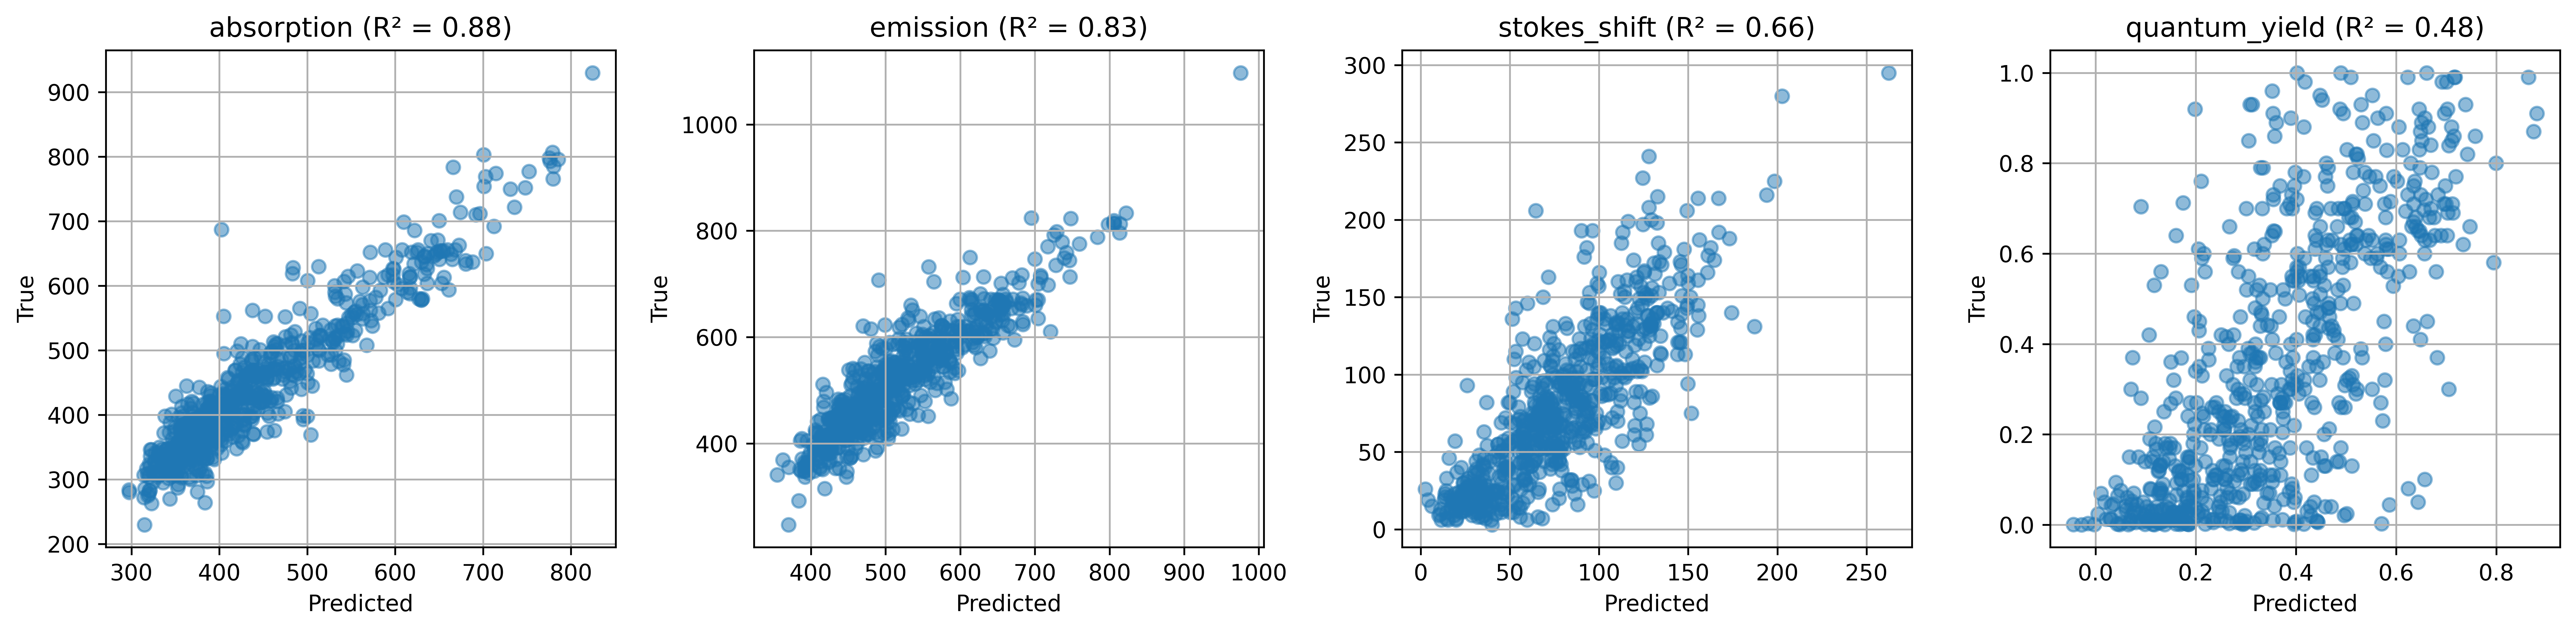

In [31]:
def plot_r2_scatter(y_true: pd.DataFrame, y_pred: np.ndarray, targets=None):
    """绘制 R² 散点图"""
    if targets is None:
        targets = y_true.columns.tolist()
    
    plt.figure(figsize=(16, 4), dpi=600)
    for i, target in enumerate(targets):
        plt.subplot(1, len(targets), i + 1)
        plt.scatter(y_pred[:, i], y_true[target], alpha=0.5)
        r2 = r2_score(y_true[target], y_pred[:, i])
        plt.title(f"{target} (R² = {r2:.2f})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

targets = ["absorption", "emission", "stokes_shift", "quantum_yield"]
plot_r2_scatter(y_test, y_pred, targets=targets)